In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'norm_data.parquet'
data = pd.read_parquet(file_path)

# Step 1: Handle missing values
# Drop rows with missing pickup or dropoff times as they're crucial for time series analysis
data = data.dropna(subset=['pickup_datetime', 'dropoff_datetime'])

# Step 2: Convert datetime columns to datetime type
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data['dropoff_datetime'] = pd.to_datetime(data['dropoff_datetime'])

# Step 3: Filter data for the year 2024
data_2024 = data[data['pickup_datetime'].dt.year == 2024]

# Step 4: Set pickup_datetime as the index for time series
data_2024.set_index('pickup_datetime', inplace=True)

# Step 5: Resample data to daily frequency and aggregate relevant features
daily_data_2024 = data_2024.resample('D').agg({
    'total_amount': 'sum',  # Sum of fares per day
    'trip_distance': 'mean',  # Average trip distance per day
    'fare_amount': 'mean',  # Average fare per day
    'tip_amount': 'mean',  # Average tip per day
    'avg_speed': 'mean'  # Average speed per day
}).dropna()

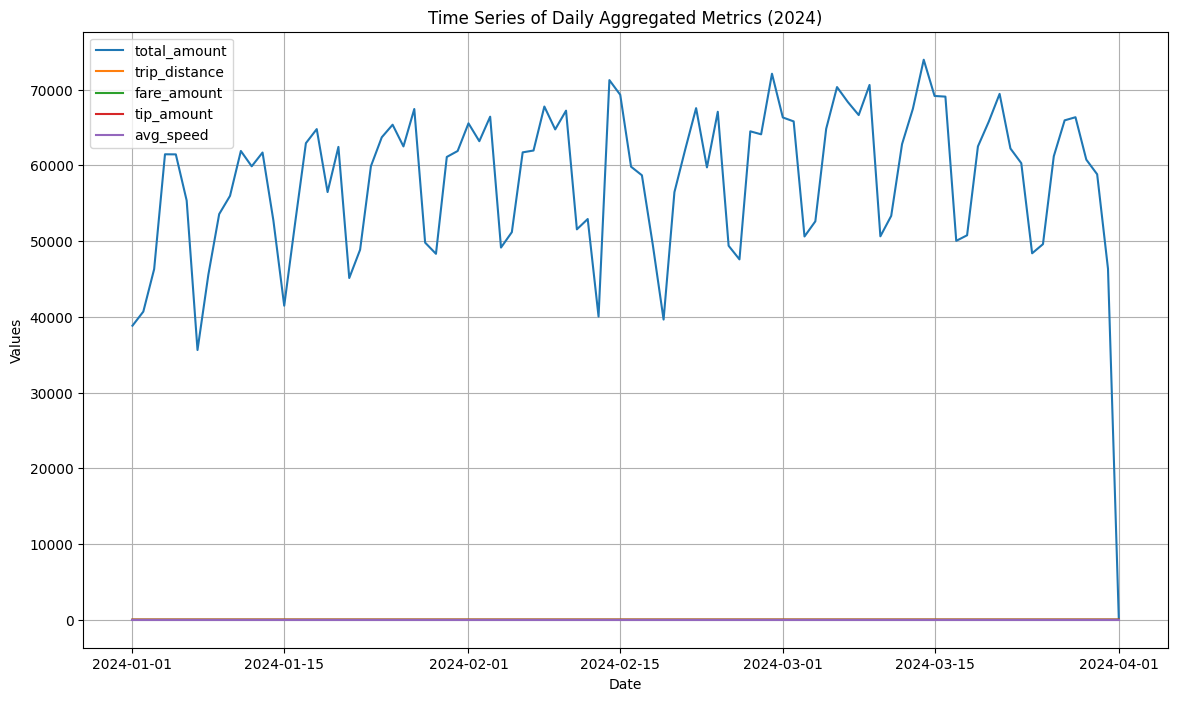

In [2]:
# Step 6: Visualize the trends
plt.figure(figsize=(14, 8))
for column in daily_data_2024.columns:
    plt.plot(daily_data_2024.index, daily_data_2024[column], label=column)
plt.title('Time Series of Daily Aggregated Metrics (2024)')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()

In [5]:
# Step 7: Save the processed dataset for 2024
processed_file_path = 'processed_time_series_2024.csv'
daily_data_2024.to_csv(processed_file_path)
print(f"Processed 2024 dataset saved to {processed_file_path}")

Processed 2024 dataset saved to processed_time_series_2024.csv


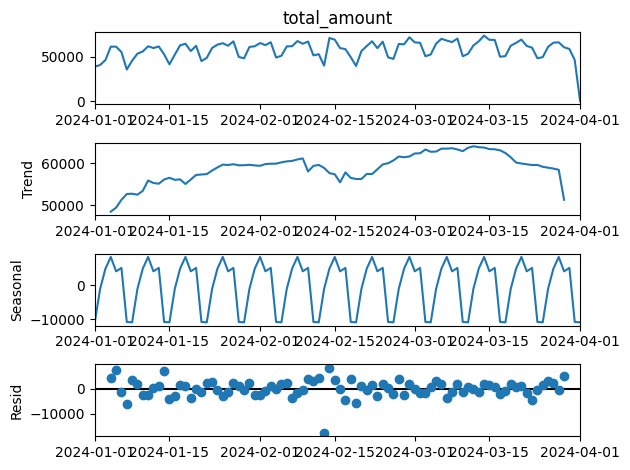

In [7]:
# Step 8: Prepare data for a simple time series model (e.g., ARIMA)
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

# Decompose the total_amount time series for 2024
result_2024 = seasonal_decompose(daily_data_2024['total_amount'], model='additive', period=7)
result_2024.plot()
plt.show()

C:\Users\syedf\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\syedf\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:           total_amount   No. Observations:                   92
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -969.087
Date:                Fri, 06 Dec 2024   AIC                           1944.174
Time:                        10:01:28   BIC                           1951.707
Sample:                    01-01-2024   HQIC                          1947.213
                         - 04-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6324      0.180      3.522      0.000       0.280       0.984
ma.L1         -0.8871      0.145     -6.105      0.000      -1.172      -0.602
sigma2      1.044e+08   1.32e-09   7.93e+16      0.0

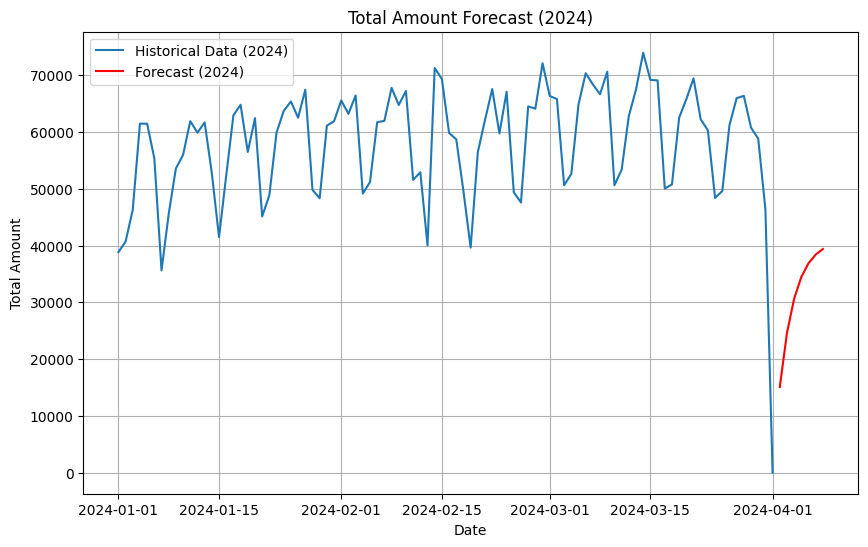

In [8]:
# Fit a simple ARIMA model on total_amount for 2024
model_2024 = ARIMA(daily_data_2024['total_amount'], order=(1, 1, 1))
model_fit_2024 = model_2024.fit()
print(model_fit_2024.summary())

# Forecast the next 7 days in 2024
forecast_2024 = model_fit_2024.forecast(steps=7)
print("7-Day Forecast (2024):")
print(forecast_2024)

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(daily_data_2024['total_amount'], label='Historical Data (2024)')
plt.plot(forecast_2024.index, forecast_2024, label='Forecast (2024)', color='red')
plt.title('Total Amount Forecast (2024)')
plt.xlabel('Date')
plt.ylabel('Total Amount')
plt.legend()
plt.grid()
plt.show()

C:\Users\syedf\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


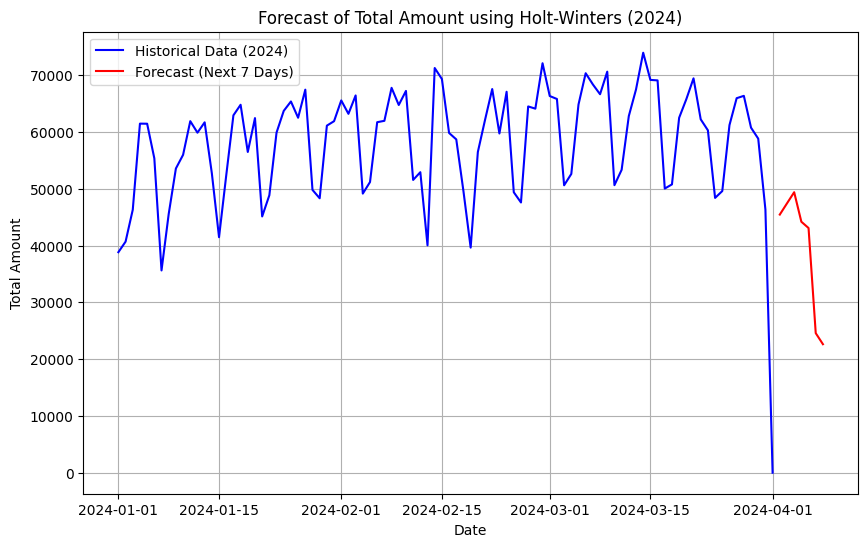

In [86]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt

# Fit the Holt-Winters model for total_amount
hw_model_total = ExponentialSmoothing(
    daily_data_2024['total_amount'], 
    seasonal='add', 
    trend='add', 
    seasonal_periods=7
).fit()

# Forecast the next 7 days
hw_forecast_total = hw_model_total.forecast(steps=7)

# Plot Historical Data and Forecast
plt.figure(figsize=(10, 6))
plt.plot(daily_data_2024['total_amount'], label='Historical Data (2024)', color='blue')
plt.plot(hw_forecast_total.index, hw_forecast_total, label='Forecast (Next 7 Days)', color='red')
plt.title('Forecast of Total Amount using Holt-Winters (2024)')
plt.xlabel('Date')
plt.ylabel('Total Amount')
plt.legend()
plt.grid()
plt.show()


17:52:36 - cmdstanpy - INFO - Chain [1] start processing
17:52:37 - cmdstanpy - INFO - Chain [1] done processing


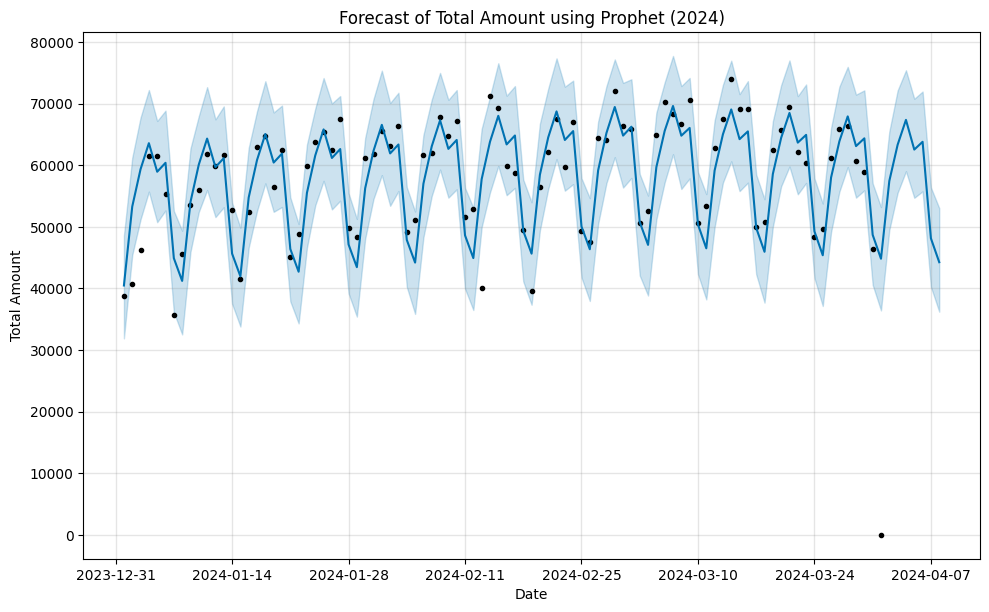

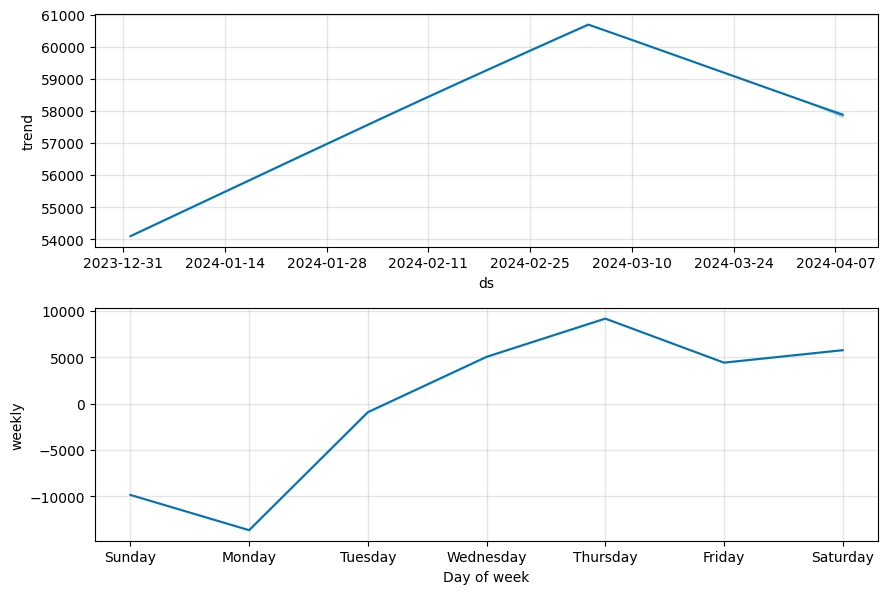

In [87]:
from prophet import Prophet

# Prepare the data for Prophet
prophet_data_total = daily_data_2024.reset_index()[['pickup_datetime', 'total_amount']]
prophet_data_total.columns = ['ds', 'y']  # Rename columns for Prophet compatibility

# Fit the Prophet model
prophet_model_total = Prophet()
prophet_model_total.fit(prophet_data_total)

# Forecast the next 7 days
future_total = prophet_model_total.make_future_dataframe(periods=7)
forecast_total = prophet_model_total.predict(future_total)

# Plot Forecast
prophet_model_total.plot(forecast_total)
plt.title('Forecast of Total Amount using Prophet (2024)')
plt.xlabel('Date')
plt.ylabel('Total Amount')
plt.show()

# Optional: Plot Forecast Components (Trend, Seasonality)
prophet_model_total.plot_components(forecast_total)
plt.show()


C:\Users\syedf\AppData\Local\Temp\ipykernel_46100\2913192231.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2024['hour'] = data_2024.index.hour
C:\Users\syedf\AppData\Local\Temp\ipykernel_46100\2913192231.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2024['day_of_week'] = data_2024.index.dayofweek


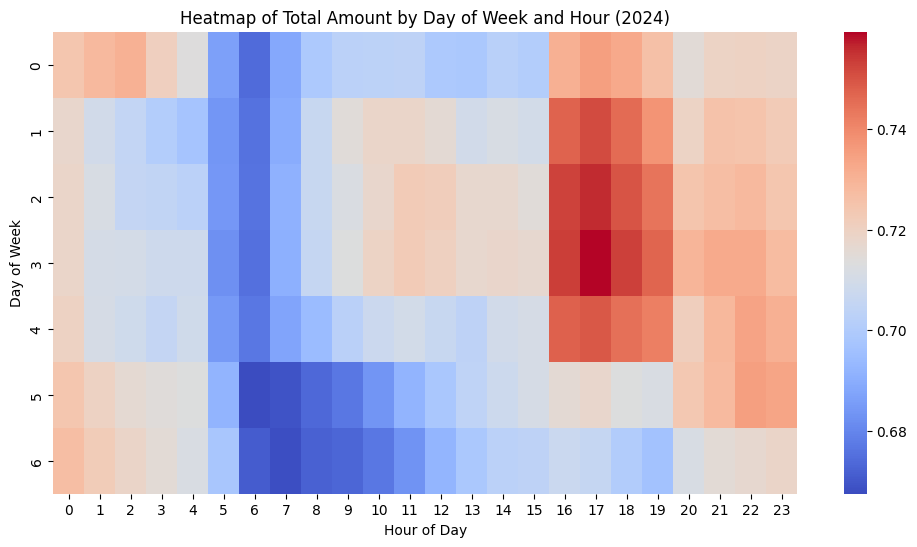

In [73]:
import seaborn as sns
import numpy as np

# Step 1: Heatmap of Total Amount by Day of Week and Hour
data_2024['hour'] = data_2024.index.hour
data_2024['day_of_week'] = data_2024.index.dayofweek
heatmap_data = data_2024.groupby(['day_of_week', 'hour'])['total_amount'].mean().unstack()

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=False, fmt='.2f')
plt.title('Heatmap of Total Amount by Day of Week and Hour (2024)')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()

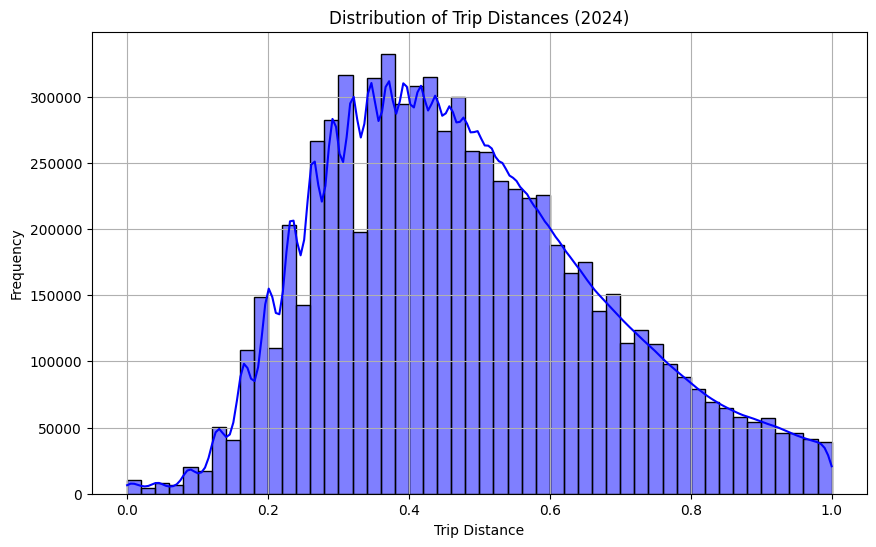

In [74]:
# Step 2: Distribution of Trip Distances
plt.figure(figsize=(10, 6))
sns.histplot(data_2024['trip_distance'], kde=True, bins=50, color='blue')
plt.title('Distribution of Trip Distances (2024)')
plt.xlabel('Trip Distance')
plt.ylabel('Frequency')
plt.grid()
plt.show()

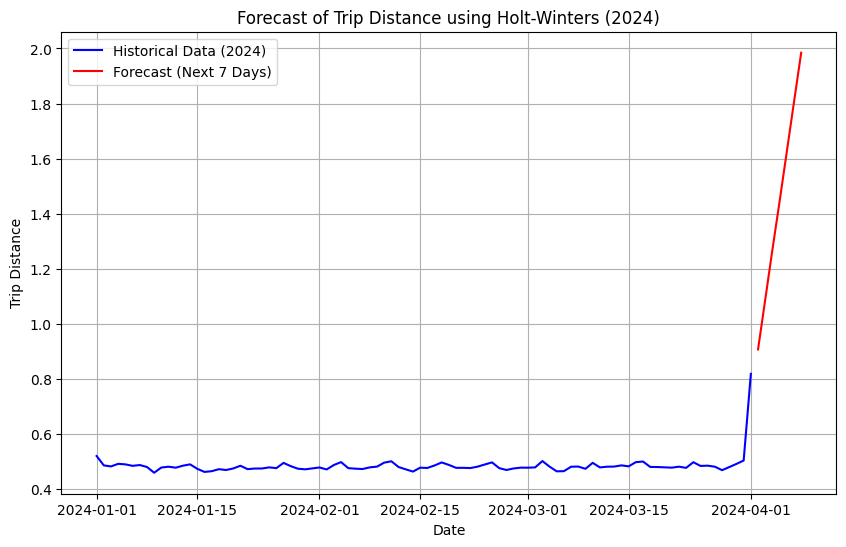

In [84]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt

# Exponential Smoothing Model for Trip Distance
hw_model_distance = ExponentialSmoothing(
    daily_data_2024['trip_distance'],
    seasonal='add', 
    trend='add', 
    seasonal_periods=7
).fit()

# Forecast the Next 7 Days
hw_forecast_distance = hw_model_distance.forecast(steps=7)

# Plot Historical Data and Forecast
plt.figure(figsize=(10, 6))
plt.plot(daily_data_2024['trip_distance'], label='Historical Data (2024)', color='blue')
plt.plot(hw_forecast_distance.index, hw_forecast_distance, label='Forecast (Next 7 Days)', color='red')
plt.title('Forecast of Trip Distance using Holt-Winters (2024)')
plt.xlabel('Date')
plt.ylabel('Trip Distance')
plt.legend()
plt.grid()
plt.show()


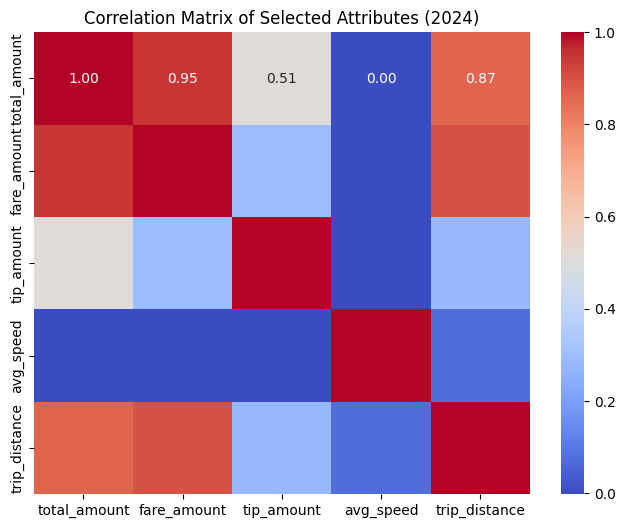

In [75]:
# Step 3: Correlation Matrix Heatmap
numeric_cols = ['total_amount', 'fare_amount', 'tip_amount', 'avg_speed', 'trip_distance']
corr_matrix = data_2024[numeric_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Selected Attributes (2024)')
plt.show()

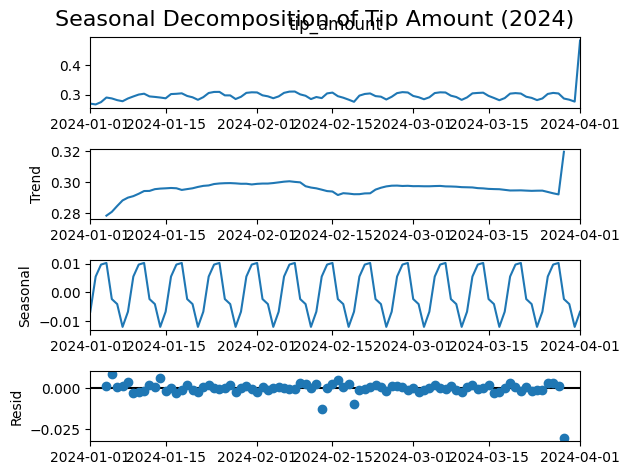

In [76]:
# Step 4: Time Series Decomposition for Tip Amount
result_tip = seasonal_decompose(daily_data_2024['tip_amount'], model='additive', period=7)
result_tip.plot()
plt.suptitle('Seasonal Decomposition of Tip Amount (2024)', fontsize=16)
plt.show()

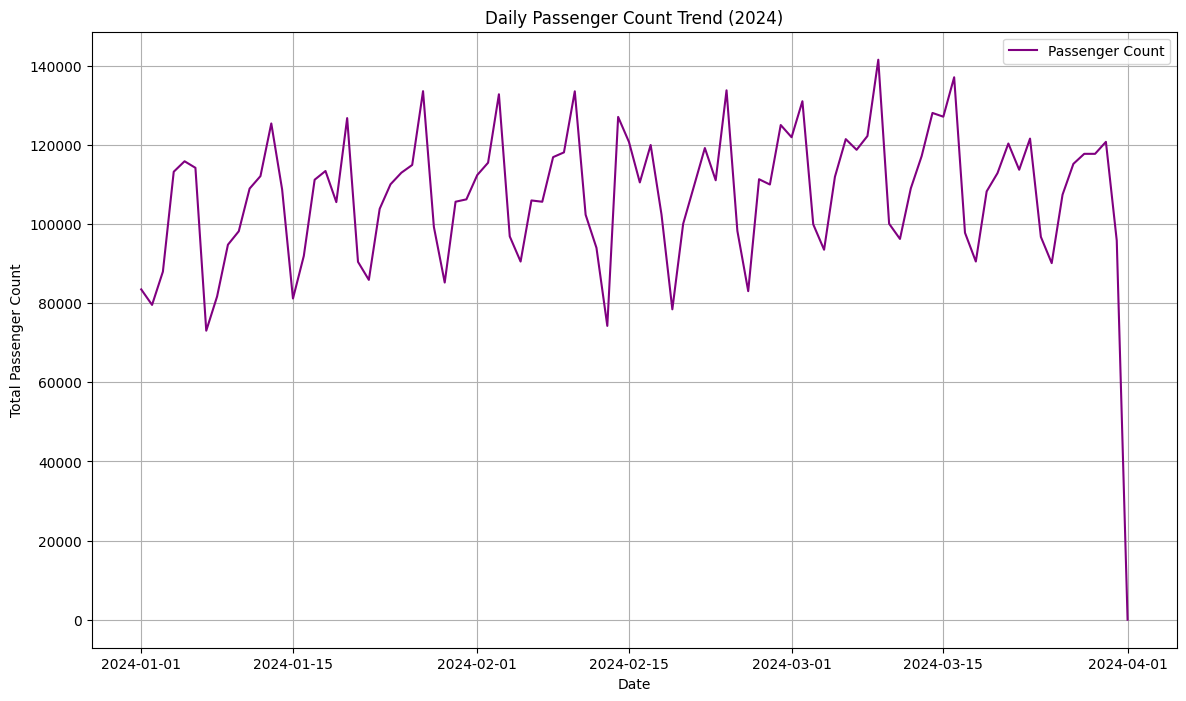

In [77]:
# Step 5: Daily Passenger Count Trend
daily_passenger_count = data_2024.resample('D').agg({'passenger_count': 'sum'}).dropna()

plt.figure(figsize=(14, 8))
plt.plot(daily_passenger_count.index, daily_passenger_count['passenger_count'], label='Passenger Count', color='purple')
plt.title('Daily Passenger Count Trend (2024)')
plt.xlabel('Date')
plt.ylabel('Total Passenger Count')
plt.legend()
plt.grid()
plt.show()

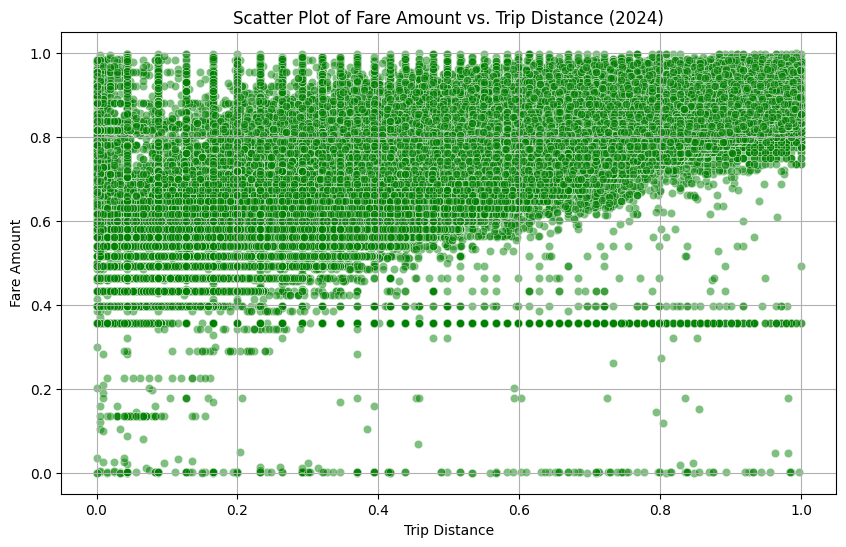

In [78]:
# Step 6: Scatter Plot of Fare Amount vs. Trip Distance
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data_2024, x='trip_distance', y='fare_amount', alpha=0.5, color='green')
plt.title('Scatter Plot of Fare Amount vs. Trip Distance (2024)')
plt.xlabel('Trip Distance')
plt.ylabel('Fare Amount')
plt.grid()
plt.show()


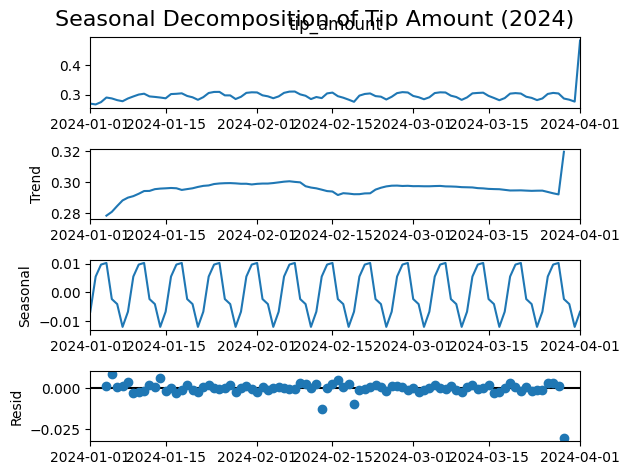

C:\Users\syedf\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\syedf\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:             tip_amount   No. Observations:                   92
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 214.374
Date:                Thu, 05 Dec 2024   AIC                           -422.748
Time:                        17:46:09   BIC                           -415.215
Sample:                    01-01-2024   HQIC                          -419.709
                         - 04-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0145     31.969      0.000      1.000     -62.644      62.674
ma.L1          0.0146     31.849      0.000      1.000     -62.408      62.437
sigma2         0.0005    4.4e-05     11.970      0.0

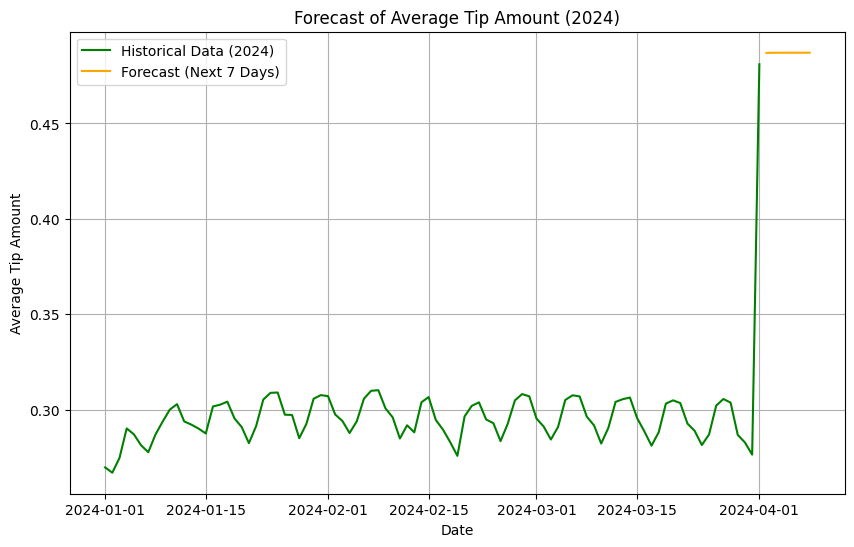

In [79]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Step 1: Seasonal Decomposition for Tip Amount
result_tip = seasonal_decompose(daily_data_2024['tip_amount'], model='additive', period=7)
result_tip.plot()
plt.suptitle('Seasonal Decomposition of Tip Amount (2024)', fontsize=16)
plt.show()

# Step 2: ARIMA Model for Tip Amount
model_tip = ARIMA(daily_data_2024['tip_amount'], order=(1, 1, 1))  # Adjust order based on ACF/PACF plots if needed
model_fit_tip = model_tip.fit()
print(model_fit_tip.summary())

# Step 3: Forecast the Next 7 Days of Average Tip Amount
forecast_tip = model_fit_tip.forecast(steps=7)
print("7-Day Forecast for Tip Amount:")
print(forecast_tip)

# Step 4: Plot the Historical Data and Forecast
plt.figure(figsize=(10, 6))
plt.plot(daily_data_2024['tip_amount'], label='Historical Data (2024)', color='green')
plt.plot(forecast_tip.index, forecast_tip, label='Forecast (Next 7 Days)', color='orange')
plt.title('Forecast of Average Tip Amount (2024)')
plt.xlabel('Date')
plt.ylabel('Average Tip Amount')
plt.legend()
plt.grid()
plt.show()


7-Day Forecast for Tip Amount (Holt-Winters):
2024-04-02    0.308058
2024-04-03    0.312555
2024-04-04    0.314094
2024-04-05    0.303849
2024-04-06    0.300000
2024-04-07    0.292495
2024-04-08    0.311455
Freq: D, dtype: float64


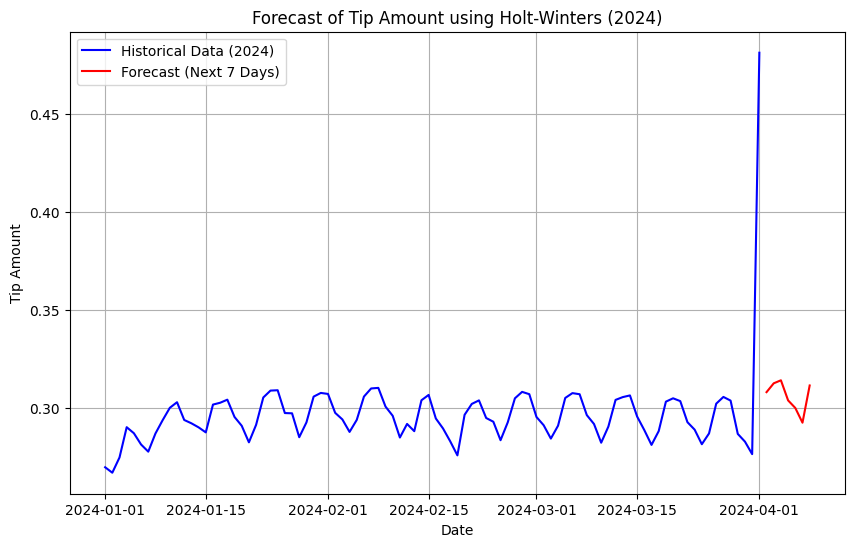

In [80]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Step 1: Fit an Exponential Smoothing Model for Tip Amount
hw_model_tip = ExponentialSmoothing(
    daily_data_2024['tip_amount'], 
    seasonal='add', 
    trend='add', 
    seasonal_periods=7
).fit()

# Step 2: Forecast the Next 7 Days
hw_forecast_tip = hw_model_tip.forecast(steps=7)
print("7-Day Forecast for Tip Amount (Holt-Winters):")
print(hw_forecast_tip)

# Step 3: Plot Historical Data and Forecast
plt.figure(figsize=(10, 6))
plt.plot(daily_data_2024['tip_amount'], label='Historical Data (2024)', color='blue')
plt.plot(hw_forecast_tip.index, hw_forecast_tip, label='Forecast (Next 7 Days)', color='red')
plt.title('Forecast of Tip Amount using Holt-Winters (2024)')
plt.xlabel('Date')
plt.ylabel('Tip Amount')
plt.legend()
plt.grid()
plt.show()


In [82]:
pip install prophet


     --------------------------------------- 13.3/13.3 MB 31.2 MB/s eta 0:00:00
     ---------------------------------------- 94.5/94.5 kB 5.3 MB/s eta 0:00:00
     ---------------------------------------- 1.2/1.2 MB 9.3 MB/s eta 0:00:00


17:48:37 - cmdstanpy - INFO - Chain [1] start processing
17:48:38 - cmdstanpy - INFO - Chain [1] done processing


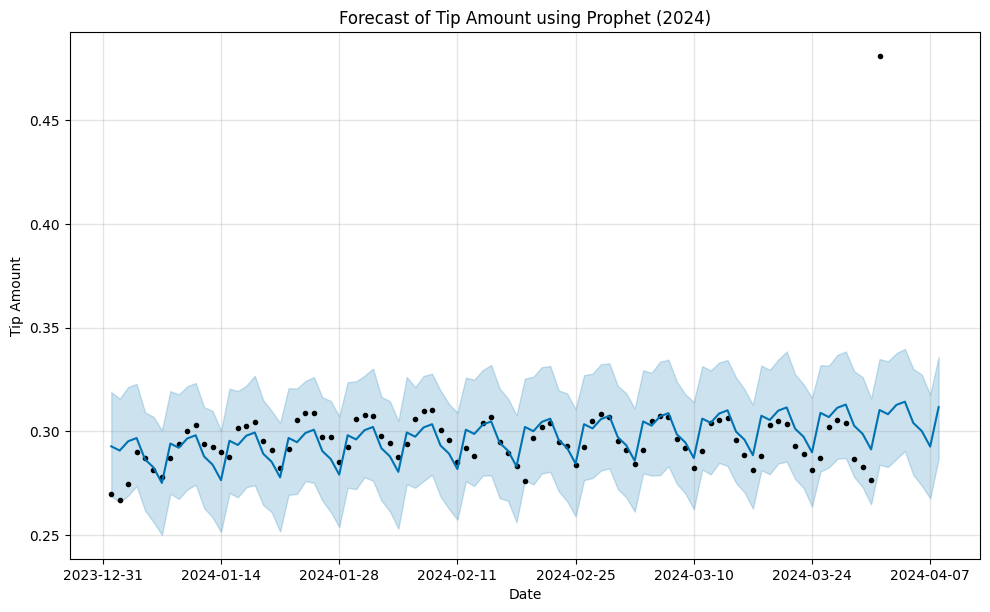

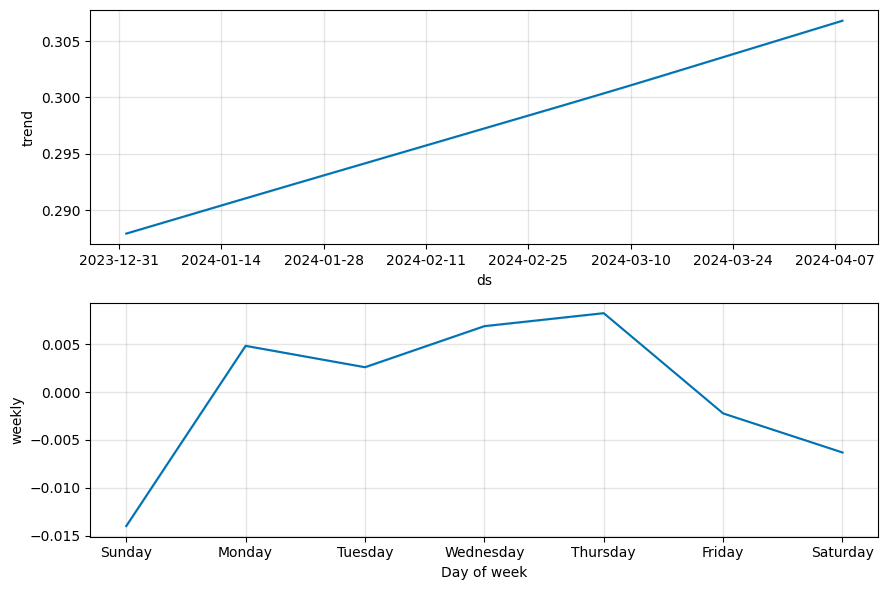

In [83]:
from prophet import Prophet

# Step 1: Prepare Data for Prophet
prophet_data = daily_data_2024.reset_index()[['pickup_datetime', 'tip_amount']]
prophet_data.columns = ['ds', 'y']  # Rename columns for Prophet compatibility

# Step 2: Fit the Prophet Model
prophet_model = Prophet()
prophet_model.fit(prophet_data)

# Step 3: Forecast the Next 7 Days
future = prophet_model.make_future_dataframe(periods=7)
forecast = prophet_model.predict(future)

# Step 4: Plot Forecast
prophet_model.plot(forecast)
plt.title('Forecast of Tip Amount using Prophet (2024)')
plt.xlabel('Date')
plt.ylabel('Tip Amount')
plt.show()

# Optional: Plot Forecast Components (Trend, Seasonality)
prophet_model.plot_components(forecast)
plt.show()

In [15]:
# Calculate Seasonality Strength
seasonality_strength = result_2024.seasonal.var() / (result_2024.seasonal.var() + result_2024.resid.var())
print(f"Seasonality Strength: {seasonality_strength:.4f}")

# Residual Variance
residual_variance = result_2024.resid.var()
print(f"Residual Variance: {residual_variance:.4f}")

Seasonality Strength: 0.8230
Residual Variance: 11936083.8261


In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calculate MAE and RMSE for ARIMA model
y_true = daily_data_2024['total_amount'][-7:]  # Use last 7 days of actual data
y_pred = model_fit_2024.forecast(steps=7)

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"ARIMA Model Metrics:\n- MAE: {mae:.2f}\n- RMSE: {rmse:.2f}")

ARIMA Model Metrics:
- MAE: 31229.05
- RMSE: 33573.85


In [24]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit the Holt-Winters model for total_amount
hw_model_total = ExponentialSmoothing(
    daily_data_2024['total_amount'], 
    seasonal='add', 
    trend='add', 
    seasonal_periods=7
).fit()

# Forecast the next 7 days
hw_forecast_total = hw_model_total.forecast(steps=7)

# Actual values for the last 7 days
y_true = daily_data_2024['total_amount'][-7:]

# Calculate MAPE for Holt-Winters
y_pred_hw = hw_forecast_total[:len(y_true)]
mape_hw = np.mean(np.abs((y_true - y_pred_hw) / y_true)) * 100

# SSE
sse_hw = np.sum((y_true - y_pred_hw)**2)

print(f"Holt-Winters Metrics:\n- MAPE: {mape_hw:.2f}%\n- SSE: {sse_hw:.2f}")

Holt-Winters Metrics:
- MAPE: nan%
- SSE: 0.00


C:\Users\syedf\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


10:17:01 - cmdstanpy - INFO - Chain [1] start processing
10:17:02 - cmdstanpy - INFO - Chain [1] done processing


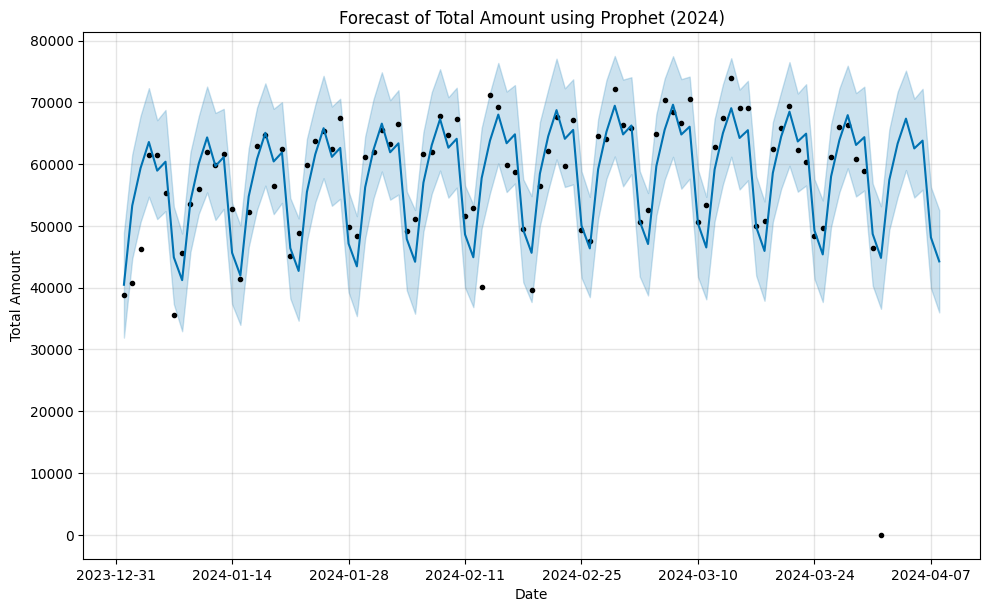

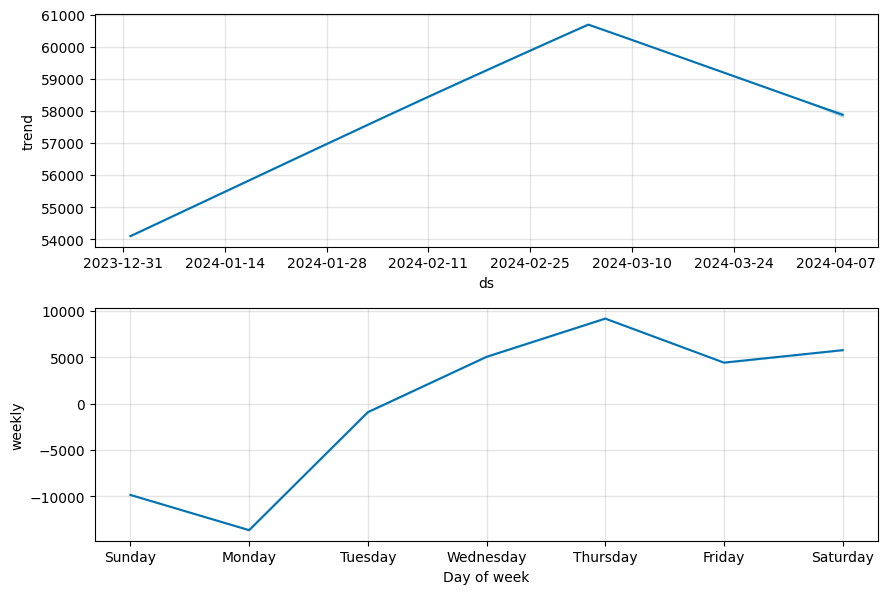

Prophet Model Metrics:
- MAE: 8598.12
- RMSE: 16950.21


In [25]:
from prophet import Prophet

# Prepare the data for Prophet
prophet_data_total = daily_data_2024.reset_index()[['pickup_datetime', 'total_amount']]
prophet_data_total.columns = ['ds', 'y']  # Rename columns for Prophet compatibility

# Fit the Prophet model
prophet_model_total = Prophet()
prophet_model_total.fit(prophet_data_total)

# Create a dataframe for future predictions
future_total = prophet_model_total.make_future_dataframe(periods=7)

# Generate the forecast
forecast_total = prophet_model_total.predict(future_total)

# Plot the forecast
prophet_model_total.plot(forecast_total)
plt.title('Forecast of Total Amount using Prophet (2024)')
plt.xlabel('Date')
plt.ylabel('Total Amount')
plt.show()

# Optional: Plot Forecast Components (Trend, Seasonality)
prophet_model_total.plot_components(forecast_total)
plt.show()

from sklearn.metrics import mean_absolute_error, mean_squared_error

# Extract actual and predicted values for Prophet
y_true_prophet = prophet_data_total['y'][-7:]
y_pred_prophet = forecast_total['yhat'][-7:]

mae_prophet = mean_absolute_error(y_true_prophet, y_pred_prophet)
rmse_prophet = np.sqrt(mean_squared_error(y_true_prophet, y_pred_prophet))

print(f"Prophet Model Metrics:\n- MAE: {mae_prophet:.2f}\n- RMSE: {rmse_prophet:.2f}")


C:\Users\syedf\AppData\Local\Temp\ipykernel_38516\1054400174.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2024['hour'] = data_2024.index.hour
C:\Users\syedf\AppData\Local\Temp\ipykernel_38516\1054400174.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2024['day_of_week'] = data_2024.index.dayofweek


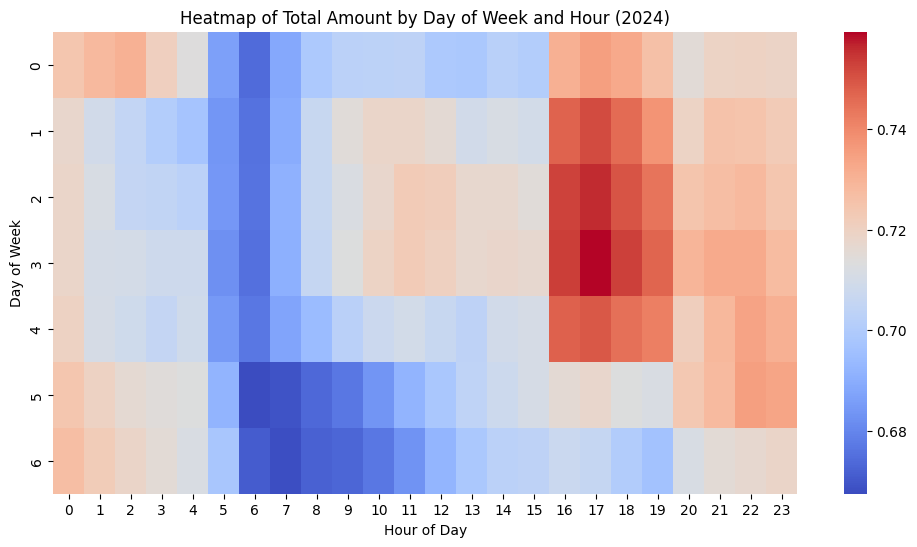

Variance of Total Amount in Heatmap: 0.00


In [26]:

import pandas as pd

# Extract day of the week and hour from the datetime index
data_2024['hour'] = data_2024.index.hour
data_2024['day_of_week'] = data_2024.index.dayofweek

# Group by day of week and hour, then calculate the average total_amount
heatmap_data = data_2024.groupby(['day_of_week', 'hour'])['total_amount'].mean().unstack()

import seaborn as sns
import matplotlib.pyplot as plt

# Create the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=False, fmt='.2f', cbar=True)
plt.title('Heatmap of Total Amount by Day of Week and Hour (2024)')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()


# Variance of total_amount by day of week and hour
variance_total_amount = heatmap_data.var().mean()
print(f"Variance of Total Amount in Heatmap: {variance_total_amount:.2f}")


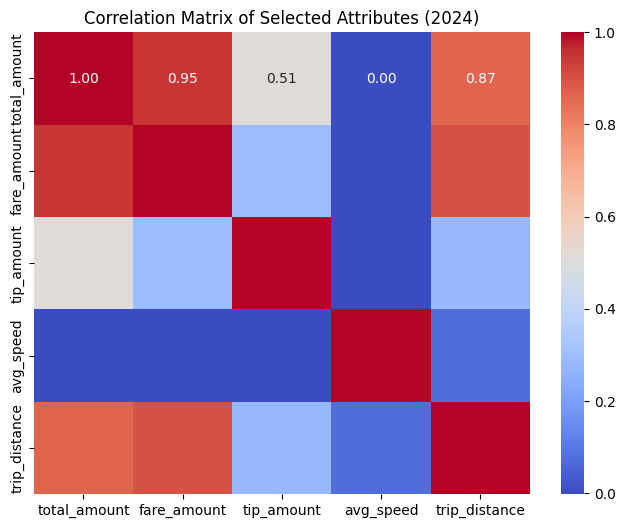

Strong Correlations:
total_amount   fare_amount      0.946646
               trip_distance    0.865343
fare_amount    total_amount     0.946646
               trip_distance    0.901953
trip_distance  total_amount     0.865343
               fare_amount      0.901953
dtype: float64


In [27]:
# Select numeric columns
numeric_cols = ['total_amount', 'fare_amount', 'tip_amount', 'avg_speed', 'trip_distance']

# Calculate the correlation matrix
corr_matrix = data_2024[numeric_cols].corr()

import seaborn as sns
import matplotlib.pyplot as plt

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Correlation Matrix of Selected Attributes (2024)')
plt.show()


# Correlation Matrix
correlation_threshold = 0.7
strong_correlations = corr_matrix[(corr_matrix > correlation_threshold) & (corr_matrix != 1)].stack()

print("Strong Correlations:")
print(strong_correlations)


In [21]:
from statsmodels.tsa.stattools import adfuller

# Augmented Dickey-Fuller Test
adf_test = adfuller(daily_data_2024['total_amount'])
print(f"ADF Statistic: {adf_test[0]:.2f}")
print(f"P-Value: {adf_test[1]:.4f}")
if adf_test[1] < 0.05:
    print("The time series is stationary.")
else:
    print("The time series is non-stationary.")

ADF Statistic: -2.14
P-Value: 0.2280
The time series is non-stationary.


In [22]:
# Pearson Correlation for Scatter Plot
from scipy.stats import pearsonr

corr, _ = pearsonr(data_2024['trip_distance'], data_2024['fare_amount'])
print(f"Pearson Correlation between Trip Distance and Fare Amount: {corr:.2f}")

Pearson Correlation between Trip Distance and Fare Amount: 0.90


In [28]:
report = {
    "Seasonality Strength": seasonality_strength,
    "Residual Variance": residual_variance,
    "ARIMA MAE": mae,
    "ARIMA RMSE": rmse,
    "Holt-Winters MAPE": mape_hw,
    "Holt-Winters SSE": sse_hw,
    "Prophet MAE": mae_prophet,
    "Prophet RMSE": rmse_prophet,
    "Heatmap Variance": variance_total_amount,
    "ADF Test P-Value": adf_test[1],
    "Trip-Fare Correlation": corr
}

for key, value in report.items():
    print(f"{key}: {value:.2f}")

Seasonality Strength: 0.82
Residual Variance: 11936083.83
ARIMA MAE: 31229.05
ARIMA RMSE: 33573.85
Holt-Winters MAPE: nan
Holt-Winters SSE: 0.00
Prophet MAE: 8598.12
Prophet RMSE: 16950.21
Heatmap Variance: 0.00
ADF Test P-Value: 0.23
Trip-Fare Correlation: 0.90
